In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
import scipy
%matplotlib inline

#### Loading images and Converting to array

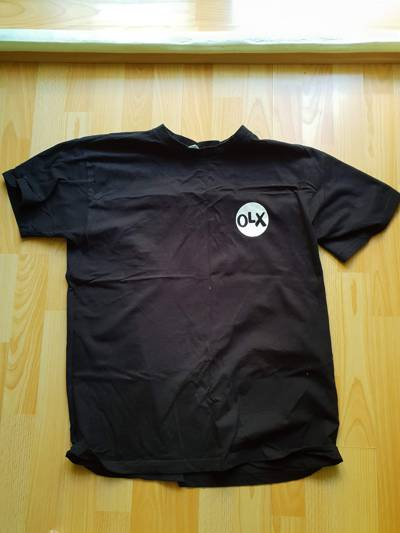

In [2]:
# Path and File Setup
path = './train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'

# Image Loading
load_img(fullname)

In [3]:
img = load_img(fullname, target_size=(299, 299))

# Converting to Array
x = np.array(img)
x.shape

(299, 299, 3)

#### Pre-trained Convolutional Neural Networks

https://keras.io/api/applications/

In [5]:
# Loading Pre-trained Model
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

In [6]:
# Preparing Input
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [7]:
# Preprocessing and Prediction
X = preprocess_input(X)
pred = model.predict(X)
decode_predictions(pred)

1/1 [==============================] - 3s 3s/step


[[('n03595614', 'jersey', 0.6819631),
  ('n02916936', 'bulletproof_vest', 0.038140006),
  ('n04370456', 'sweatshirt', 0.034324776),
  ('n03710637', 'maillot', 0.011354242),
  ('n04525038', 'velvet', 0.0018453602)]]

In [4]:
# Data augmentation and batch loading
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory(
    './train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    './validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
base_model.trainable = False

# Model Architecture
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


#### Adjusting learning_rate

We tested four learning rates:
learning_rates = [0.0001, 0.001, 0.01, 0.1]

Results showed:

- 0.0001: Too slow to converge, training was suboptimal
- 0.001: ✅ Best performance, good balance of learning speed and stability
- 0.01: Started well but could be unstable
- 0.1: Too high, likely caused erratic training

The experiment led us to choose 0.001 as our optimal learning rate

In [21]:
# Optimizer Setup
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Loss Function
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Training
history = model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10
96/96 [==============================] - 409s 4s/step - loss: 0.0109 - accuracy: 0.9980 - val_loss: 1.4916 - val_accuracy: 0.8094
Epoch 2/10
96/96 [==============================] - 332s 3s/step - loss: 0.0033 - accuracy: 0.9997 - val_loss: 1.4779 - val_accuracy: 0.8035
Epoch 3/10
96/96 [==============================] - 314s 3s/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 1.4612 - val_accuracy: 0.8123
Epoch 4/10
96/96 [==============================] - 334s 3s/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 1.4637 - val_accuracy: 0.8152
Epoch 5/10
96/96 [==============================] - 370s 4s/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 1.4426 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 445s 5s/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 1.4387 - val_accuracy: 0.8123
Epoch 7/10
96/96 [==============================] - 434s 5s/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 1.4546 - val_accuracy: 0.8152
Epoch 8/10
96

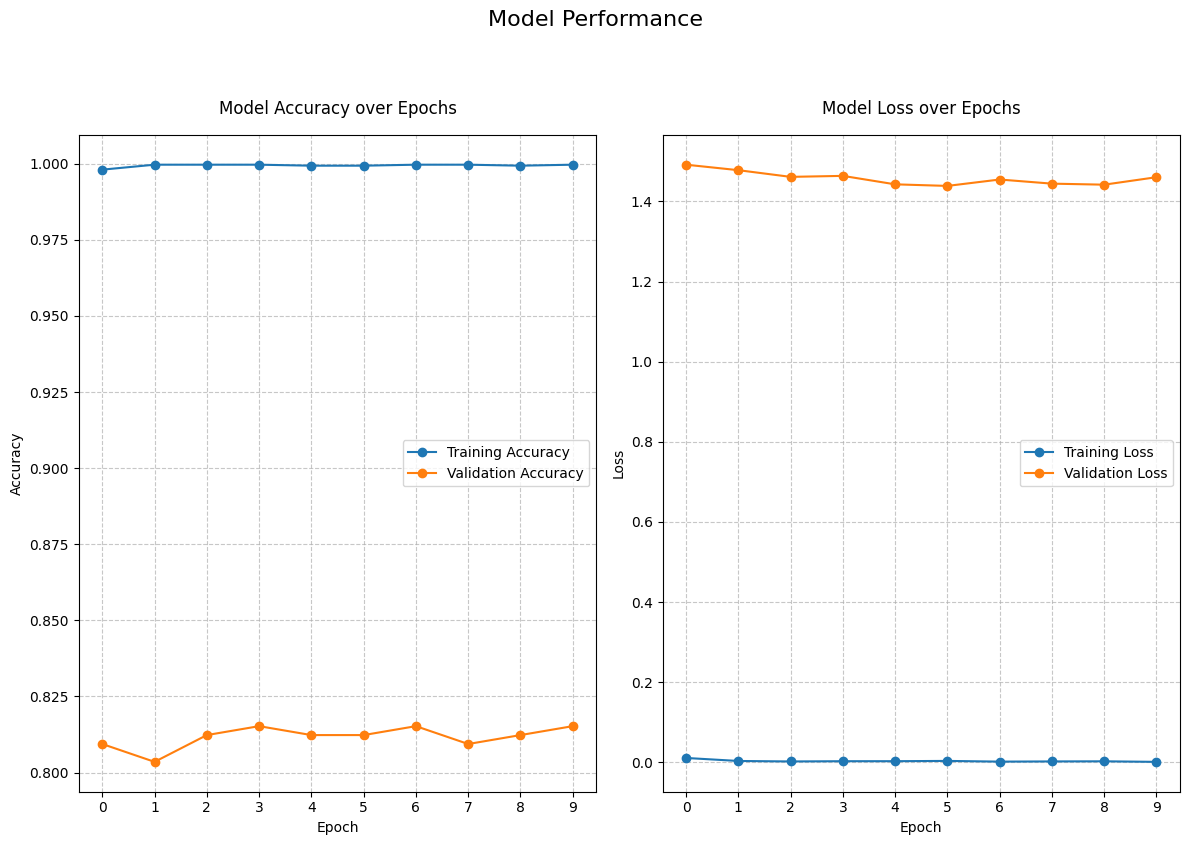

In [22]:
plt.figure(figsize=(12, 8))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy over Epochs', pad=15)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(10))
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss over Epochs', pad=15)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(10))
plt.legend()

plt.suptitle('Model Performance', fontsize=16, y=1.05)
plt.tight_layout()

#### Checkpointing

In [24]:
def make_model(learning_rate=0.001, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Saving Initial Model Weights
model.save_weights('model_v1.h5', save_format='h5')

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

learning_rate = 0.001
model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/10
96/96 [==============================] - 395s 4s/step - loss: 1.1104 - accuracy: 0.6297 - val_loss: 0.7255 - val_accuracy: 0.7889
Epoch 2/10
96/96 [==============================] - 343s 4s/step - loss: 0.6293 - accuracy: 0.7881 - val_loss: 0.6592 - val_accuracy: 0.7918
Epoch 3/10
96/96 [==============================] - 340s 4s/step - loss: 0.5044 - accuracy: 0.8318 - val_loss: 0.5877 - val_accuracy: 0.8240
Epoch 4/10
96/96 [==============================] - 338s 4s/step - loss: 0.4301 - accuracy: 0.8615 - val_loss: 0.5745 - val_accuracy: 0.8240
Epoch 5/10
96/96 [==============================] - 329s 3s/step - loss: 0.3700 - accuracy: 0.8830 - val_loss: 0.5685 - val_accuracy: 0.8211
Epoch 6/10
96/96 [==============================] - 312s 3s/step - loss: 0.3253 - accuracy: 0.9032 - val_loss: 0.5708 - val_accuracy: 0.8270
Epoch 7/10
96/96 [==============================] - 306s 3s/step - loss: 0.2890 - accuracy: 0.9224 - val_loss: 0.5419 - val_accuracy: 0.8094
Epoch 8/10
96

Performance:

- Epoch 1: 0.789 (78.9%)
- Epoch 2: 0.792 (79.2%)    - Small improvement
- Epoch 3: 0.824 (82.4%)    - Significant jump
- Epoch 6: 0.827 (82.7%)    - Small improvement
- Epoch 10: 0.83 (83.0%)    - Final improvement

#### Adding Inner Dense Layers

In [5]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(10)(inner)
    
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

learning_rate = 0.001

scores = {}

# Testing different inner layer sizes
for size in [10, 100, 1000]:
    print(size)
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

10
Epoch 1/10
96/96 [==============================] - 364s 4s/step - loss: 1.8874 - accuracy: 0.2686 - val_loss: 1.6579 - val_accuracy: 0.3490
Epoch 2/10
96/96 [==============================] - 312s 3s/step - loss: 1.3713 - accuracy: 0.5655 - val_loss: 1.1692 - val_accuracy: 0.6657
Epoch 3/10
96/96 [==============================] - 297s 3s/step - loss: 1.0390 - accuracy: 0.6623 - val_loss: 0.9451 - val_accuracy: 0.7097
Epoch 4/10
96/96 [==============================] - 243s 3s/step - loss: 0.8316 - accuracy: 0.7233 - val_loss: 0.7871 - val_accuracy: 0.7507
Epoch 5/10
96/96 [==============================] - 266s 3s/step - loss: 0.7042 - accuracy: 0.7709 - val_loss: 0.7428 - val_accuracy: 0.7625
Epoch 6/10
96/96 [==============================] - 349s 4s/step - loss: 0.6277 - accuracy: 0.7920 - val_loss: 0.7129 - val_accuracy: 0.7771
Epoch 7/10
96/96 [==============================] - 300s 3s/step - loss: 0.5649 - accuracy: 0.8110 - val_loss: 0.6825 - val_accuracy: 0.7889
Epoch 8/10

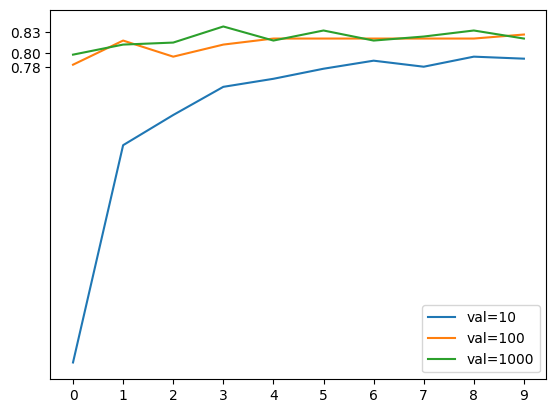

In [9]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.83])
plt.legend()

#### Regularization and Dropout

In [10]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    # Added dropout layer after the dense layer
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

0.0
Epoch 1/30
96/96 [==============================] - 505s 5s/step - loss: 0.9579 - accuracy: 0.6640 - val_loss: 0.6907 - val_accuracy: 0.7742
Epoch 2/30
96/96 [==============================] - 320s 3s/step - loss: 0.5080 - accuracy: 0.8289 - val_loss: 0.6232 - val_accuracy: 0.8152
Epoch 3/30
96/96 [==============================] - 321s 3s/step - loss: 0.3593 - accuracy: 0.8739 - val_loss: 0.5459 - val_accuracy: 0.8328
Epoch 4/30
96/96 [==============================] - 317s 3s/step - loss: 0.2636 - accuracy: 0.9146 - val_loss: 0.5731 - val_accuracy: 0.8123
Epoch 5/30
96/96 [==============================] - 292s 3s/step - loss: 0.1923 - accuracy: 0.9469 - val_loss: 0.5974 - val_accuracy: 0.8211
Epoch 6/30
96/96 [==============================] - 288s 3s/step - loss: 0.1340 - accuracy: 0.9723 - val_loss: 0.5803 - val_accuracy: 0.8211
Epoch 7/30
96/96 [==============================] - 293s 3s/step - loss: 0.0856 - accuracy: 0.9857 - val_loss: 0.6031 - val_accuracy: 0.8182
Epoch 8/3

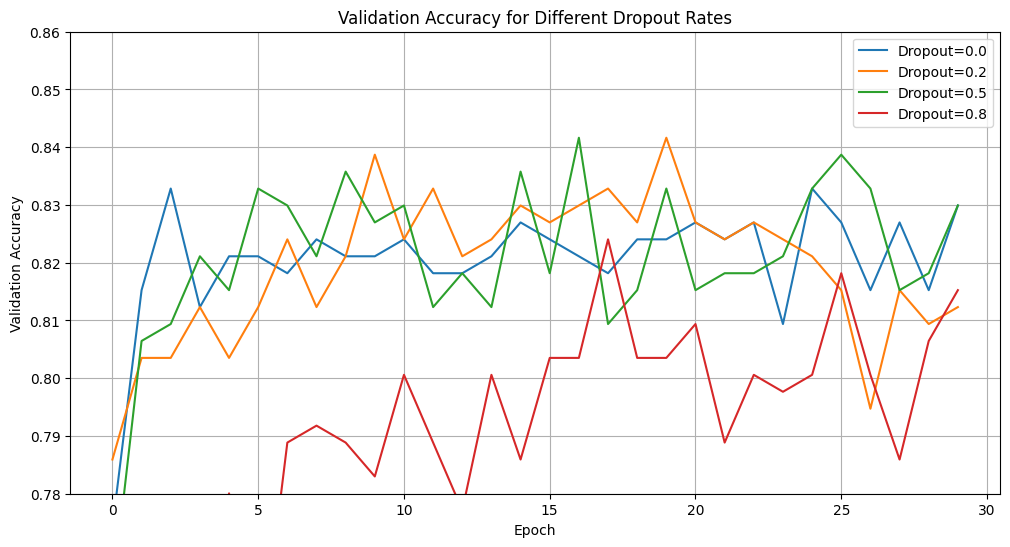

In [11]:
plt.figure(figsize=(12, 6))
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=f'Dropout={droprate}')

plt.title('Validation Accuracy for Different Dropout Rates')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.ylim(0.78, 0.86)
plt.grid(True)
plt.legend()

- Dropout=0.0: Relatively stable but lower ceiling
- Dropout=0.2: Most consistent performance
- Dropout=0.5: Shows good peaks but more variable
- Dropout=0.8: Significantly worse and more unstable performance

#### Data Augmentation

In [15]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds = train_gen.flow_from_directory(
    './train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Epoch 1/50
96/96 [==============================] - 321s 3s/step - loss: 1.0653 - accuracy: 0.6392 - val_loss: 0.6455 - val_accuracy: 0.7830
Epoch 2/50
96/96 [==============================] - 296s 3s/step - loss: 0.6092 - accuracy: 0.7823 - val_loss: 0.6238 - val_accuracy: 0.7830
Epoch 3/50
96/96 [==============================] - 279s 3s/step - loss: 0.4549 - accuracy: 0.8432 - val_loss: 0.6193 - val_accuracy: 0.7918
Epoch 4/50
96/96 [==============================] - 277s 3s/step - loss: 0.3493 - accuracy: 0.8898 - val_loss: 0.5630 - val_accuracy: 0.8094
Epoch 5/50
96/96 [==============================] - 292s 3s/step - loss: 0.2863 - accuracy: 0.9084 - val_loss: 0.5403 - val_accuracy: 0.8182
Epoch 6/50
96/96 [==============================] - 282s 3s/step - loss: 0.2246 - accuracy: 0.9374 - val_loss: 0.5379 - val_accuracy: 0.8211
Epoch 7/50
96/96 [==============================] - 282s 3s/step - lo

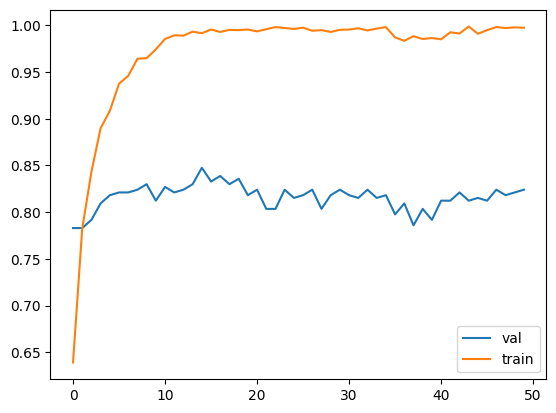

In [16]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

The large and growing gap between training (>90%) and validation (~75%) accuracy is a classic sign of overfitting.

#### Training larger models

In [3]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model


input_size = 299

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    './train',
    target_size=(input_size, input_size),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    './validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

learning_rate = 0.0005
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Epoch 1/50
96/96 [==============================] - 1317s 14s/step - loss: 1.0156 - accuracy: 0.6871 - val_loss: 0.5916 - val_accuracy: 0.7830
Epoch 2/50
96/96 [==============================] - 1236s 13s/step - loss: 0.5260 - accuracy: 0.8250 - val_loss: 0.4658 - val_accuracy: 0.8358
Epoch 3/50
96/96 [==============================] - 1262s 13s/step - loss: 0.4418 - accuracy: 0.8543 - val_loss: 0.4357 - val_accuracy: 0.8416
Epoch 4/50
96/96 [==============================] - 1099s 11s/step - loss: 0.3706 - accuracy: 0.8794 - val_loss: 0.4093 - val_accuracy: 0.8534
Epoch 5/50
96/96 [==============================] - 1094s 11s/step - loss: 0.3510 - accuracy: 0.8810 - val_loss: 0.3753 - val_accuracy: 0.8768
Epoch 6/50
96/96 [==============================] - 1083s 11s/step - loss: 0.3161 - accuracy: 0.8937 - val_loss: 0.3983 - val_accuracy: 0.8622
Epoch 7/50
96/96 [==============================] - 1096s

xception_v4_1_31_0.906 breaks down to:

- Epoch: 31 
- Validation Accuracy: 0.906 (90.6%)

This is a significant improvement from our previous results:

- Previous best (150x150 model): 83% validation accuracy
- New best (299x299 model): 90.6% validation accuracy

#### Using the model

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

model = keras.models.load_model('xception_v4_1_31_0.906.h5')

model.evaluate(test_ds)

Found 372 images belonging to 10 classes.
12/12 [==============================] - 138s 11s/step - loss: 0.2711 - accuracy: 0.9005


[0.2711081802845001, 0.9005376100540161]

Test Loss: 0.2711
- This is a good low loss value
- Indicates the model is confident in its predictions
- Consistent with our validation performance


Test Accuracy: 0.9005 (90.05%)
- Very close to our validation accuracy (90.6%)
- Shows excellent generalization
- Demonstrates model isn't overfitting

#### Checking Predictions

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

path = 'test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'
img = load_img(path, target_size=(299, 299))

x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

# Making Prediction
pred = model.predict(X)

classes = [
    'dress', 'hat', 'longsleeve', 'outwear', 'pants',
    'shirt', 'shoes', 'shorts', 'skirt', 't-shirt'
]

dict(zip(classes, pred[0]))

1/1 [==============================] - 2s 2s/step


{'dress': -3.2190979,
 'hat': -4.640114,
 'longsleeve': -1.9111109,
 'outwear': -2.3231099,
 'pants': 11.927148,
 'shirt': -3.018988,
 'shoes': -2.935765,
 'shorts': 4.6299663,
 'skirt': -3.6479166,
 't-shirt': -2.77608}

In [ ]:
import tensorflow as tf

probabilities = tf.nn.softmax(pred[0])
predictions = dict(zip(classes, probabilities))
sorted_predictions = dict(sorted(predictions.items(), key=lambda x: x[1], reverse=True))

# Print top prediction
for class_name, prob in list(sorted_predictions.items())[:1]:
    print(f"{class_name}: {prob*100:.2f}%")

pants: 99.93%


The large positive value for 'pants' (the correct class) shows the model is very confident in its prediction. 

Also interesting to note that 'shorts' has the second-highest score, which makes intuitive sense as shorts and pants share similar characteristics.

#### Summary

1. Pre-trained Models & Transfer Learning:

- Used Xception pre-trained on ImageNet
- Leveraged existing knowledge about general image features
- Saved significant training time and resources


2. Architecture Understanding:

- Convolutional layers extract features from images
- GlobalAveragePooling2D reduces spatial dimensions
- Dense layers make final classification decisions


3. Methodical Development Process:

- Started with smaller 150x150 images to prototype quickly
- Scaled up to 299x299 for better performance
- Got final accuracy above 90% on test set


4. Training Optimization:

- Experimented with learning rates (found 0.001 then 0.0005 optimal)
- Used ModelCheckpoint to save best models
- Added dropout (0.2 worked best) to prevent overfitting
- Implemented data augmentation for robustness


5. Key Results:

- Initial model: ~83% accuracy
- Final model: ~90% accuracy